%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import fastai

In [2]:
from pathlib import Path
import pickle
from PIL import Image

import matplotlib.pyplot as plt

from fastai.vision import ImageDataBunch
from fastai.vision import LabelLists
from fastai.vision import get_transforms

In [3]:
import random
import numpy as np
import os
import torch
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [4]:
import torch, fastai
torch.__version__, fastai.__version__

('1.1.0', '1.0.58')

In [5]:
cifar100_stats = (torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343]),
 torch.tensor([0.26733428587924035, 0.2564384629170881, 0.2761504713256853]))

In [6]:
path = Path('cifar100')
train_file = 'train'
test_file = 'test'

In [7]:
data = ImageDataBunch.from_folder(path,
                                  train=f'train_data',
                                  valid=f'valid_data',
                                  ds_tfms=get_transforms(),
                                  num_workers=10,
                                  bs=256,
                                 ).normalize(cifar100_stats)


CPU times: user 3.07 s, sys: 468 ms, total: 3.54 s
Wall time: 3.45 s


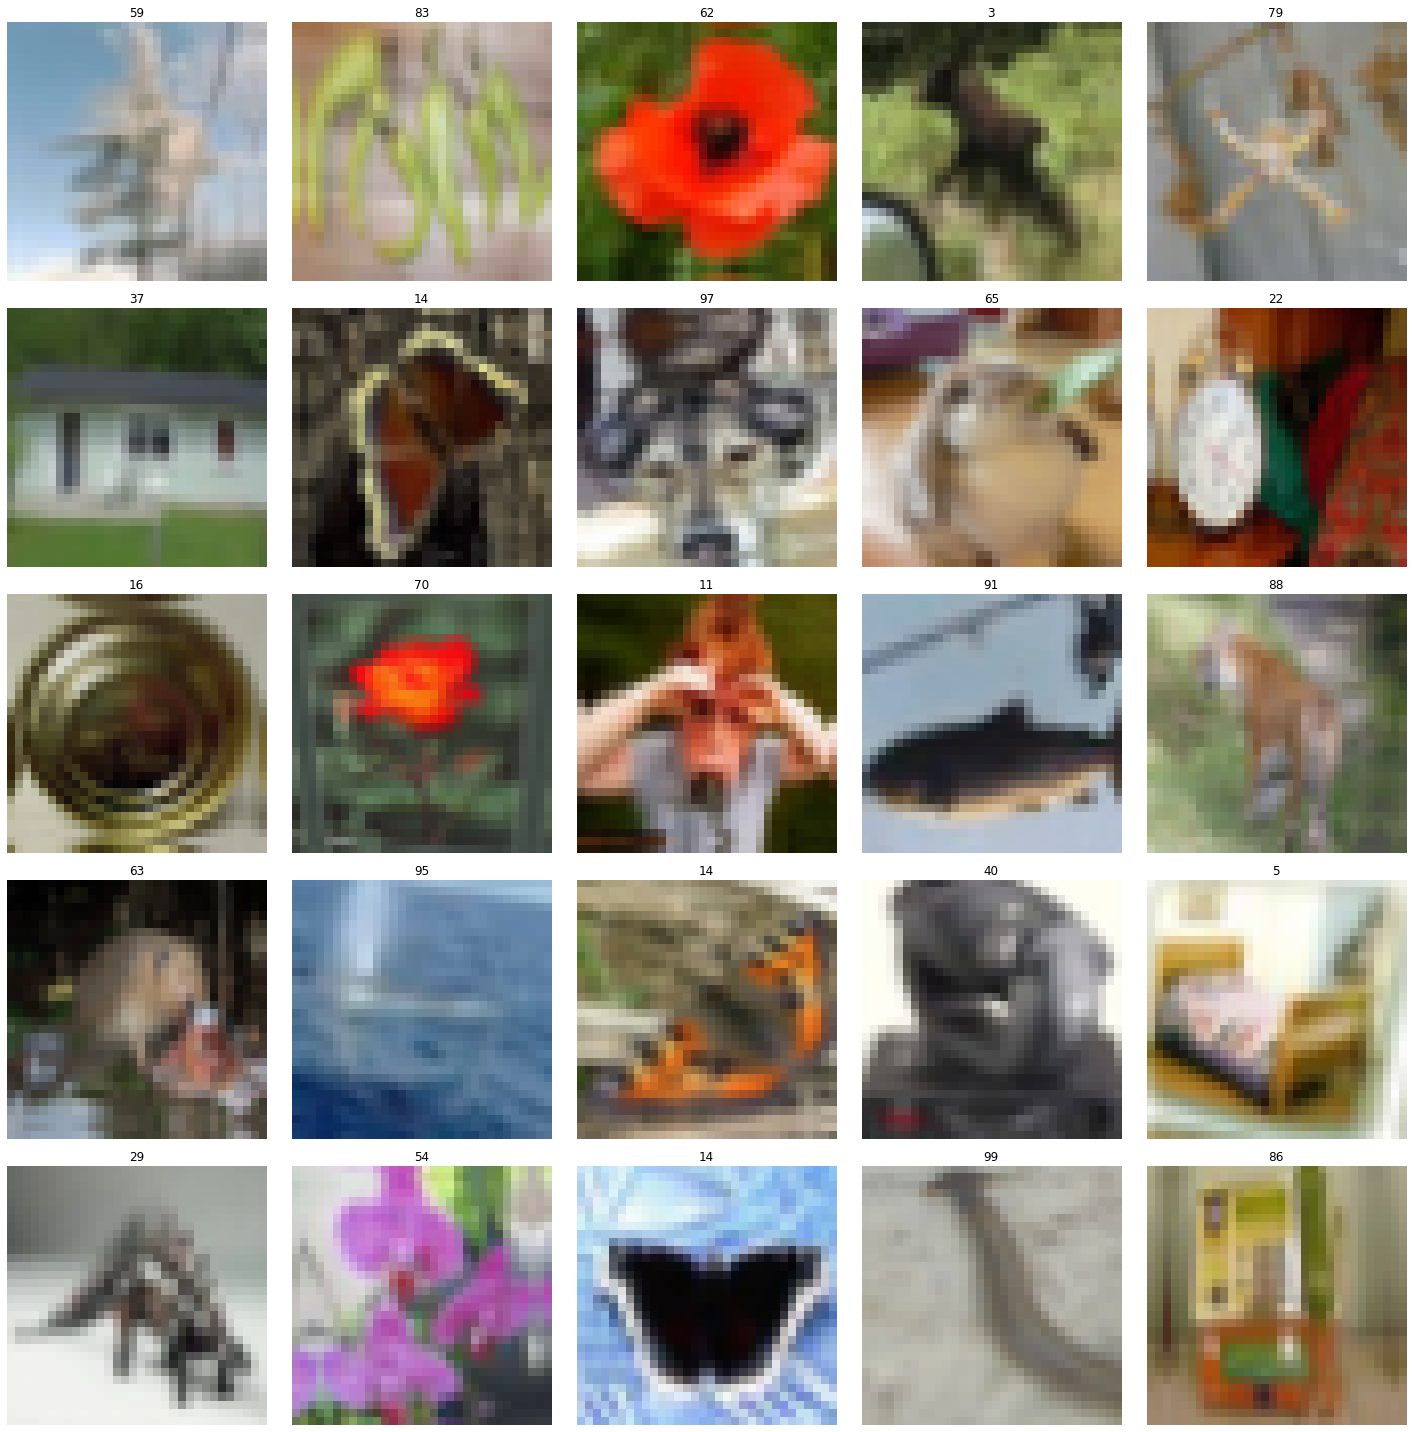

In [8]:
%%time
data.show_batch()

In [9]:
from torchvision import models
from fastai.vision import cnn_learner, accuracy, create_body
from fastai.callbacks import model_sizes, hook_outputs

In [10]:
from torch import nn
from torchsummary import summary
import numpy as np

In [11]:
from fastai.vision.models import wrn_22, WideResNet

In [12]:
from fastai.basic_train import Learner

In [13]:
learn = Learner(data, WideResNet(num_groups=3, N=3, num_classes=100, k=6, drop_p=0.), metrics=[accuracy]).mixup()

In [14]:
from fastai.callbacks import SaveModelCallback
from torch import nn
import torch.nn.functional as F

In [15]:
learn.load('FINAL_WRN_NO_FL');

In [16]:
from fastai.vision import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
(interp.y_true == interp.pred_class).float().mean()

tensor(0.8046)

In [17]:
from torchsummary import summary

In [18]:
summary(learn.model.eval(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 96, 32, 32]           1,536
            Conv2d-4           [-1, 96, 32, 32]          13,824
       BatchNorm2d-5           [-1, 96, 32, 32]             192
              ReLU-6           [-1, 96, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]          82,944
        BasicBlock-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
           Conv2d-10           [-1, 96, 32, 32]          82,944
      BatchNorm2d-11           [-1, 96, 32, 32]             192
             ReLU-12           [-1, 96, 32, 32]               0
           Conv2d-13           [-1, 96, 32, 32]          82,944
       BasicBlock-14           [-1, 96,

In [19]:
total_parameters_size = (9693108 * 16)/8 / 1000000  # In MB
str(total_parameters_size) + 'MB'

'19.386216MB'

### Total Math Operations

In [20]:
from torchstat import ModelHook
m = ModelHook(learn.model.eval().cpu(), (3, 32, 32))

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!


In [21]:
learn.model.eval().cpu()

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): BasicBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1):

In [22]:
leaf_modules = m.retrieve_leaf_modules()

In [23]:
import torchstat
torchstat.__file__

'/home/divyansh/Desktop/003-micronet/torchstat/__init__.py'

###  Calculate Multiplication operations and Addition operations in ConvLayers

In [24]:
madd_ops = []
for key, value in leaf_modules.items():
    if isinstance(value, nn.Conv2d):
        madd_ops.append(value.MAdd)
    
mul_ops, add_ops = torch.cat(madd_ops, 0).sum(0)    

In [25]:
mul_ops , add_ops, mul_ops.tolist() * 0.5 + add_ops

(tensor(1384562688), tensor(1383342080), tensor(2075623424))

###  Calculate Multiplication operations and Addition operations in Linear Layer

In [26]:
madd_ops = []
for key, value in leaf_modules.items():
    if isinstance(value, nn.Linear):
        print('appending')
        madd_ops.append(value.MAdd)
    
mul_ops, add_ops = torch.cat(madd_ops, 0).sum(0)  

appending


In [27]:
mul_ops , add_ops, mul_ops.tolist() * 0.5 + add_ops

(tensor(38400), tensor(38300), tensor(57500))

### Calculate Multiplication operations and Addition operations in AdaptiveAveragePool

In [28]:
input_shape = 1, 384, 8, 8  # From model summary
output_size = 1, 384, 1, 1  # From model summary

add_ops = 64 * 384
mul_ops = 384

mul_ops , add_ops, mul_ops * 0.5 + add_ops

(384, 24576, 24768.0)

### Calculate total ops in ReLU

In [37]:
madd_ops = []
for key, value in leaf_modules.items():
    if isinstance(value, nn.ReLU):
        print('appending')
        madd_ops.append(value.MAdd)
    
total_relu_ops = torch.cat(madd_ops, 0).sum(0)  

appending
appending
appending
appending
appending
appending
appending
appending
appending
appending


In [39]:
total_relu_ops.tolist() * 0.5

270336.0

## Total params

In [41]:
##################### conv ### Linear ## AvgPool
total_operations = 2075623424 + 57500 + 24768 + 270336
total_operations

2075976028


##  Metric Score

In [42]:
baseline_params = 36.5e6   #Million
baseline_ops = 10.49e9   # billion

In [47]:
my_total_params = 9693108
my_total_ops = 2075976028

In [48]:
(my_total_params / baseline_params) + (my_total_ops / baseline_ops)

0.46346508205335807